readings:
https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py

https://roamanalytics.com/2016/10/28/are-categorical-variables-getting-lost-in-your-random-forests/

In [2]:
!pip install seaborn

     |████████████████████████████████| 285 kB 2.8 MB/s eta 0:00:01


In [1]:
# linear algebra
import numpy as np 

# data processing
import pandas as pd 

# data visualization
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style

# Algorithms
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

### Titanic data-set
Can you predict who survived and who did not?

In [2]:
# data
test = pd.read_csv("../data/titanic/test.csv")
train = pd.read_csv("../data/titanic/train.csv")

In [3]:
total = train.isnull().sum().sort_values(ascending=False)
display(train.shape, test.shape)

(891, 12)

(418, 11)

In [4]:
total

Cabin          687
Age            177
Embarked         2
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Fare             0
dtype: int64

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
# we have to get rid of the objects somehow:
train[['Name', 'Ticket', 'Cabin']].head()

,Name,Ticket,Cabin
0,"Braund, Mr. Owen Harris",A/5 21171,NaN
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",PC 17599,C85
2,"Heikkinen, Miss. Laina",STON/O2. 3101282,NaN
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",113803,C123
4,"Allen, Mr. William Henry",373450,NaN


In [7]:
# Name is unique; Cabin hast to many Nans, Ticket is somehow unique too
train = train.drop(['Name', 'Ticket', 'Cabin'], axis = 1)
test = test.drop(['Name', 'Ticket', 'Cabin'], axis = 1)

Next, we replace the string-variables with numeric (integer) variables and fill missing values in age with the most frequent age.

In [8]:
unique_embarked = set(train.Embarked.unique()).union(test.Embarked.unique())
embarked = dict(zip(unique_embarked, list(range(len(unique_embarked)))))
unique_sex = set(train.Sex.unique()).union(test.Sex.unique())
sex = dict(zip(unique_sex, list(range(len(unique_sex)))))

data = [train, test]
for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].map(embarked)
    dataset['Sex'] = dataset['Sex'].map(sex)
    dataset['Age'] = dataset['Age'].fillna(dataset['Age'].mode().values[0])    

In [9]:
embarked

{nan: 0, 'S': 1, 'C': 2, 'Q': 3}

not necessary, but we cast our categorical variables to data-type 'category'

In [10]:
categorical = [var for var in train.columns if train[var].dtype=='O']
numerical = [var for var in train.columns if train[var].dtype!='O']
train[categorical] = train[categorical].astype('category')
test[categorical] = test[categorical].astype('category')

In [11]:
categorical

[]

### we fit a RandomForest Classifier

In [12]:
survived = train['Survived']
train = train.drop('Survived', axis=1)
rf = RandomForestClassifier()
rf.fit(train, survived)

RandomForestClassifier()

### The RandomForest Classifier comes with an feature_importances_ attribute

/home/martin/miniconda3/envs/imbalanced/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys


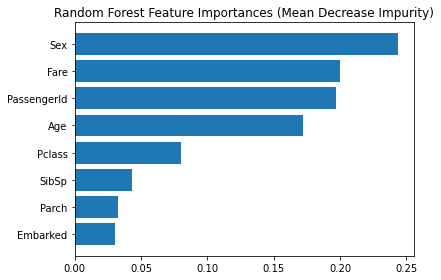

In [13]:
tree_feature_importances = rf.feature_importances_
feature_names = train.columns
sorted_idx = tree_feature_importances.argsort()
y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots()
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (Mean Decrease Impurity)")
fig.tight_layout()
plt.show()

### Why is PassengerId such an important variable?

We could even enhance the information contained in PassengerId by target-encoding this variable.<br> No information is lost, results should not be worse.

By the way, what exactly are we doing in the for-loop?

In [14]:
from category_encoders.cat_boost import CatBoostEncoder
from category_encoders.one_hot import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
k=5

encoder = CatBoostEncoder(cols = 'PassengerId')
folds = StratifiedKFold(n_splits = k, shuffle=True, random_state=1234)

test_PassId = np.zeros(test.shape[0])
train_trg = train.copy()
test_trg = test.copy()
for train_fold_idx, test_fold_idx in folds.split(train, survived):
    _ = encoder.fit_transform(train.loc[train_fold_idx], survived[train_fold_idx])
    train_trg.loc[test_fold_idx, :] = encoder.transform(train.loc[test_fold_idx])
    test_PassId += (encoder.transform(test)['PassengerId']/k)
test_trg['PassengerId'] = test_PassId

/home/martin/miniconda3/envs/imbalanced/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/martin/miniconda3/envs/imbalanced/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/martin/miniconda3/envs/imbalanced/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/martin/miniconda3/envs/imbalanced/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  

In [15]:
display(test.head(), test_trg.head())

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,1,34.5,0,0,7.8292,3
1,893,3,0,47.0,1,0,7.0000,1
2,894,2,1,62.0,0,0,9.6875,3
3,895,3,1,27.0,0,0,8.6625,1
4,896,3,0,22.0,1,1,12.2875,1


,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0.383838,3,1,34.5,0,0,7.8292,3
1,0.383838,3,0,47.0,1,0,7.0000,1
2,0.383838,2,1,62.0,0,0,9.6875,3
3,0.383838,3,1,27.0,0,0,8.6625,1
4,0.383838,3,0,22.0,1,1,12.2875,1


/home/martin/miniconda3/envs/imbalanced/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


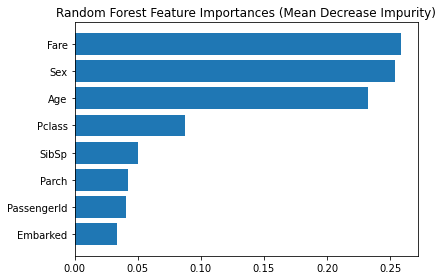

In [16]:
rf = RandomForestClassifier()
rf.fit(train_trg, survived)
tree_feature_importances = rf.feature_importances_
feature_names = train.columns
sorted_idx = tree_feature_importances.argsort()
y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots()
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (Mean Decrease Impurity)")
fig.tight_layout()
plt.show()

### Surprise!
What exactly happend? The relevant information about the target should still be contained in the mean-encoded PassengerId-variable.

### Can we make the old PassengerId-variable shine even brighter?

In [17]:
encoder = OneHotEncoder(cols = ['Age', 'Sex'])
train_oh = encoder.fit_transform(train)
test_oh = encoder.transform(test)

/home/martin/miniconda3/envs/imbalanced/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


/home/martin/miniconda3/envs/imbalanced/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


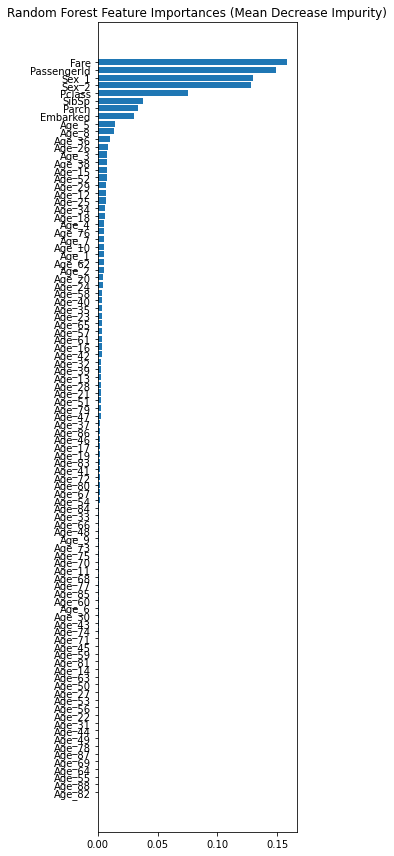

In [18]:
rf = RandomForestClassifier()
rf.fit(train_oh, survived)
tree_feature_importances = rf.feature_importances_
feature_names = train_oh.columns
sorted_idx = tree_feature_importances.argsort()
y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots(figsize=(4, 12))
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (Mean Decrease Impurity)")
fig.tight_layout()
plt.show()

# Gini-coefficient (gini impurity) for splitting variables

\begin{equation*}
\text{gini}=1-\sum_i^n P_i^2 
\end{equation*}
where $i$ is the class index;
The gini impurity measueres the purity of a node. If all elements within one node fall in one class, $P_i=1$ and the impurity is at its minimum.<br>
Gini impurity favours splitting repeatedly on continuous variables and thus cutting out regions of very low impurity. The continuous variable itself might even contain no real information at all (PassengerId).

# Permutation variable importance

In [19]:
display(train.head(), survived.head())

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,3,1,22.0,1,0,7.2500,1
1,2,1,0,38.0,1,0,71.2833,2
2,3,3,0,26.0,0,0,7.9250,1
3,4,1,0,35.0,1,0,53.1000,1
4,5,3,1,35.0,0,0,8.0500,1


0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

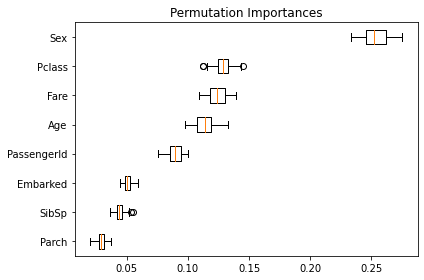

In [20]:
from sklearn.inspection import permutation_importance

rf_model = RandomForestClassifier()
rf_model.fit(train, survived)
result = permutation_importance(rf_model, train, survived,
        n_repeats=30,
        random_state=0)

sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=train.columns[sorted_idx])
ax.set_title("Permutation Importances")
fig.tight_layout()
plt.show()

In [23]:
import dtreeviz
from sklearn import tree
from dtreeviz.trees import *

classifier = tree.DecisionTreeClassifier(max_depth=5)  # limit depth of tree
classifier.fit(train, survived)

viz = dtreeviz(classifier, 
               train, 
               survived,
               target_name='survived',
               feature_names=train.columns, 
               class_names=["died", "survived"]  # need class_names for classifier
              )  
              
viz.view() 

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


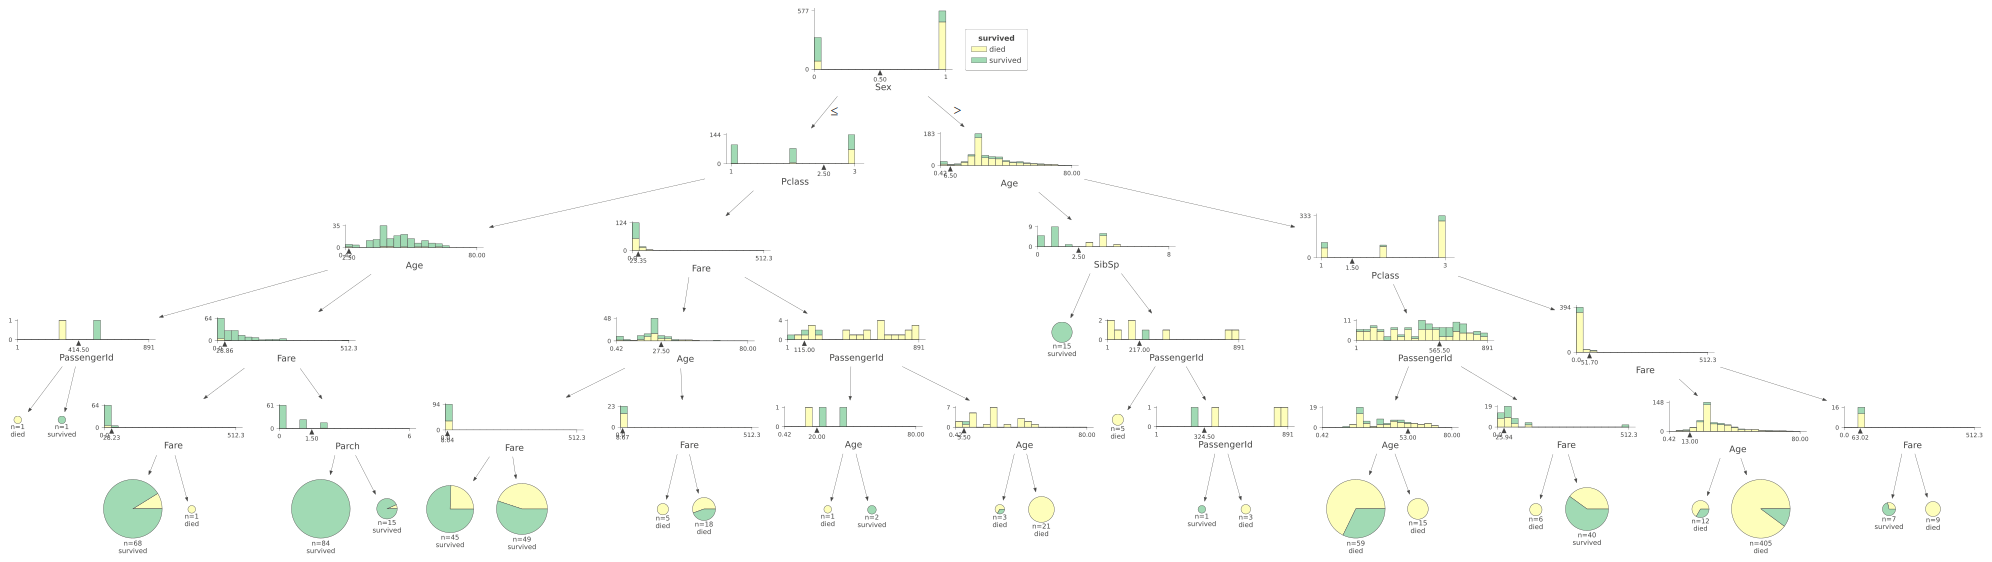

In [24]:
viz

# experiment
How well would a random variable perform?
  - some values are repeating but random
  - all values are unique and random

/home/martin/miniconda3/envs/imbalanced/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  


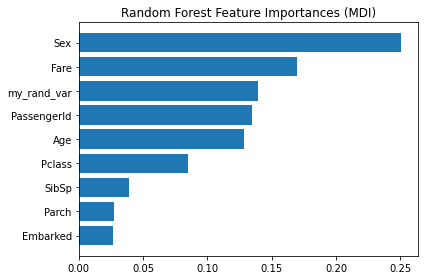

In [25]:
# simple random variable not all values unique (vs. PassengerId)

from numpy.random import randint
train_rand = train.copy()
train_rand['my_rand_var'] = randint(0, train.shape[0], train.shape[0])
rf_rand = RandomForestClassifier()
rf_rand.fit(train_rand, survived)
tree_feature_importances = rf_rand.feature_importances_
feature_names = train_rand.columns
sorted_idx = tree_feature_importances.argsort()
y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots()
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()

### Cardinality of Variable in relation to number of observations
If the ratio is 1.0, that means that we have as many different values in the variable as there are observations. The number of possible splits that just randomly lead to pure nodes is very high.

In [36]:
display(len(train_rand.Age.unique())/train.shape[0], len(train_rand.my_rand_var.unique())/train.shape[0],
       len(train_rand.PassengerId.unique())/train.shape[0])

0.09876543209876543

0.6262626262626263

1.0

When we repeatedly execute the cell below, in most cases the variable 'my_unique_rand_var' has a higher feature_importance than the 'my_unique_rand_var_sorted' variable.<br>
Why is this?<br>
Values of both variables are unique. There should be no sorting in the target-variable within the data-frame.

/home/martin/miniconda3/envs/imbalanced/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app


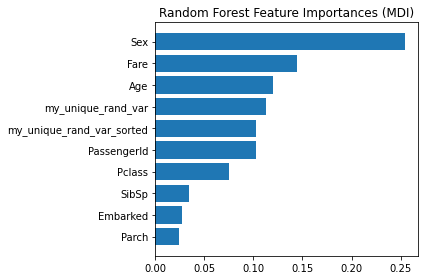

In [37]:
# simple random variable all values unique (vs. PassengerId)

from numpy.random import choice
train_rand_all_unique = train.copy()
train_rand_all_unique['my_unique_rand_var'] = choice(np.arange(train.shape[0]), train.shape[0], replace=False)
train_rand_all_unique['my_unique_rand_var_sorted'] = np.arange(train.shape[0])
rf_rand_all_unique = RandomForestClassifier()
rf_rand_all_unique.fit(train_rand_all_unique, survived)
tree_feature_importances = rf_rand_all_unique.feature_importances_
feature_names = train_rand_all_unique.columns
sorted_idx = tree_feature_importances.argsort()
y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots()
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()

<AxesSubplot:>

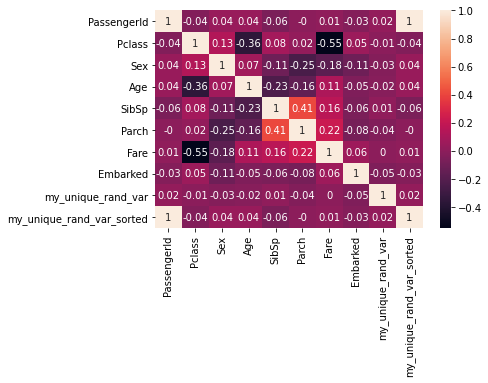

In [42]:
sns.heatmap(np.round(train_rand_all_unique.corr(), 2), annot=True)

In [112]:
train_rand_all_unique.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,my_unique_rand_var,my_unique_rand_var_sorted
0,1,3,0,22.0,1,0,7.2500,3,391,0
1,2,1,1,38.0,1,0,71.2833,1,302,1
2,3,3,1,26.0,0,0,7.9250,3,574,2
3,4,1,1,35.0,1,0,53.1000,3,205,3
4,5,3,0,35.0,0,0,8.0500,3,456,4


### Interpretation
For the interpretation of the importance-scores, this is highly relevant. As we see, PassengerId and my_unique_rand_var_sorted are highly redundant. Nonetheless, both have very high importance-scores; The accuracy of the model will not degrade if we remove one of the variables - even though both have high importance.